In [1]:
import  numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import pandas as pd
from scipy import stats,signal

In [30]:
uname    = "/scratch/cccr/roxy/panini/DATA/uwnd/uwnd.mon.mean.jjas.yearmean.1901_2015.nc"
vname    = "/scratch/cccr/roxy/panini/DATA/vwnd/vwnd.mon.mean.jjas.yearmean.1901_2015.nc"
u700     = "/scratch/cccr/roxy/panini/DATA/uwnd/uwnd.mon.mean.jjas.yearmean.1901_2015.700.nc"
v700     = "/scratch/cccr/roxy/panini/DATA/vwnd/vwnd.mon.mean.jjas.yearmean.1901_2015.700.nc"
uanomname    = "/scratch/cccr/roxy/panini/DATA/uwnd/uwnd.mon.mean.jjas.yearmean.1901_2015.anom.nc"
vanomname    = "/scratch/cccr/roxy/panini/DATA/vwnd/vwnd.mon.mean.jjas.yearmean.1901_2015.anom.nc"
hgt  = xr.open_dataset("/scratch/cccr/roxy/panini/DATA/geo-potential-height/hgt.mon.mean.jjas.yearmean.1901_2015.nc")
pc_all = xr.open_dataset("/home/cccr/roxy/athira/pc.yearmean.nc")

In [31]:
xr.open_dataset(uanomname)

<xarray.Dataset>
Dimensions:      (time: 115, bnds: 2, lon: 360, lat: 181, level: 28, nbnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 1901-07-16T12:00:00 ... 2015-07-16T12:...
  * lon          (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat          (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * level        (level) float32 1e+03 975.0 950.0 925.0 ... 20.0 10.0 5.0 1.0
Dimensions without coordinates: bnds, nbnds
Data variables:
    time_bnds    (time, bnds) datetime64[ns] ...
    time_bnds_2  (time, nbnds) float64 ...
    uwnd         (time, level, lat, lon) float32 ...
Attributes: (12/27)
    CDI:                       Climate Data Interface version 1.9.5 (http://m...
    history:                   Fri Mar 24 10:18:51 2023: cdo sub uwnd.mon.mea...
    source:                    20CRv3si 2018, Ensemble Kalman Filter, ocean (...
    institution:               NOAA ESRL Physical Sciences Division & CU/CIRE...
    Conventions:               CF-1.2
    title:                     Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3
    ...                        ...
    References:                https://www.esrl.noaa.gov/psd/data/gridded/dat...
    forcing_note:              Additional information on the external forcing...
    citation:                  Compo,G.P. <https://www.esrl.noaa.gov/psd/peop...
    citation1:                 Slivinski, L. C, G. P. Compo, J. S. Whitaker, ...
    frequency:                 year
    CDO:                       Climate Data Operators version 1.9.5 (http://m...

# VORTICITY

In [32]:
def hvorticity(u,v,grid):
    dtr = np.pi/180        ### degree to radian
    r   = 6.371*(10**6)  
    latv,lonv       =   create_mesh(u,grid)
    dV              =   np.gradient(v,axis=-1)
    dU              =   np.gradient(u*np.cos(latv*dtr),axis=-2)
    dX              =   np.gradient(lonv*dtr,axis=-1)
    dY              =   np.gradient(latv*dtr,axis=-2)               
    VOR           =     (dV/dX - dU/dY)/(r*np.cos(latv*dtr))
    return VOR

In [33]:
def check_lat(uname,uvarname):
    """
    check if latitude are in rverese order.
    Then select the specified level.
    """
    
    dua      = xr.open_dataset(uname)
    dy       = np.gradient(dua.lat) 
    if np.unique(dy)[0]<0:
        dua  = dua.reindex(latitude=dua.lat[::-1])

    return dua



In [34]:
def hvorticity_xarray(uname,vname,sellevel='all',uvarname='uwnd',vvarname='vwnd'):
    """
    input:
    uname    : u filename
    uvarname : u variable name ;'uwnd'
    vname    : v filename
    vvarname : v variable name ;'vwnd'
    dimension should be in (time,level,lon,lat)
    output:
    ds_vort : vorticity =    (dv/dx-du/dy)     s-1
    """ 
    
    dua = check_lat(uname,uvarname)
    dva = check_lat(vname,vvarname)
  
    if sellevel=='all':
        
        u      =  dua[uvarname].values
        v      =  dva[vvarname].values
        grid  =  [dua.level.values,dua.lat.values,dua.lon.values]
        
        if u.shape!=v.shape:
            raise ValueError("Dimension_mismatch between U and V")
            return
       
        VOR = hvorticity(u,v,grid)

        vor_ds = xr.Dataset({'VOR': (('time','level','lat','lon'), VOR)}, coords={'time': dua.time,'level':dua.level,'lat': dua.lat,'lon': dua.lon})

    elif sellevel == 'None':
        
        u = dua[uvarname].values
        v = dva[vvarname].values
        grid  =  [dua.lat.values,dua.lon.values]
        
        if u.shape!=v.shape:
            raise ValueError("Dimension_mismatch between U and V")
            return
        print(u.shape)

        VOR = hvorticity(u,v,grid)

        vor_ds = xr.Dataset({'VOR': (('time', 'lat','lon'), VOR)}, coords={'time': dua.time,'lat': dua.lat,'lon': dua.lon})
    
    else:
        
        u = dua.sel(level=sellevel)[uvarname].values
        v = dva.sel(level=sellevel)[vvarname].values
        grid  =  [dua.lat.values,dua.lon.values]
        
        if u.shape!=v.shape:
            raise ValueError("Dimension_mismatch between U and V")
            return
        print(u.shape)

        VOR = hvorticity(u,v,grid)

        vor_ds = xr.Dataset({'VOR': (('time', 'lat','lon'), VOR)}, coords={'time': dua.time,'lat': dua.lat,'lon': dua.lon})
    
    
    return vor_ds

In [35]:

def create_mesh(u,grid):
    """
    create a mesh grid based on the data dimension
    """
    if len(u.shape) == 4:
        time            =   np.arange(u.shape[0])
        _,_,latv, lonv  =   np.meshgrid(time,grid[0],grid[1], grid[2], indexing='ij')
    if len(u.shape) == 3:
        time            =   np.arange(u.shape[0])
        _,latv, lonv    =   np.meshgrid(time,grid[0],grid[1], indexing='ij')
    elif len(u.shape)== 2:
        latv, lonv      =   np.meshgrid(grid[0],grid[1], indexing='ij')

    return latv,lonv

## MTV (80E-100E,10N-30N)

In [36]:
vor_ds = hvorticity_xarray(uname,vname,sellevel='all',uvarname='uwnd',vvarname='vwnd')

## PC

In [37]:
pcs=pc_all.pcs.values
pcs=pcs[:-3]
index1 = pd.date_range(start=pd.datetime(1901,7,1),periods=len(pcs),freq='AS-JUL')
pcs_df = pd.DataFrame(pcs, index = index1, columns=['IPC1','IPC2','pc3'])
pcs_detrend=signal.detrend(pcs_df['IPC2'])
pcs_df_detrend = pd.DataFrame(pcs_detrend, index = index1, columns=['IPC2'])
pcs_df_detrend

/tmp/ipykernel_29921/708062951.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  index1 = pd.date_range(start=pd.datetime(1901,7,1),periods=len(pcs),freq='AS-JUL')


,IPC2
1901-07-01,0.341937
1902-07-01,0.860061
1903-07-01,1.982338
1904-07-01,-0.540364
1905-07-01,0.827523
...,...
2012-07-01,-0.567364
2013-07-01,-0.182107
2014-07-01,0.277471
2015-07-01,0.672274


# VOR-700

In [38]:
vor_700=vor_ds.sel(level='700', lon=slice(80,100), lat=slice(10,30)).mean(dim=['lat','lon'])
print(np.corrcoef(signal.detrend(vor_700['VOR']),signal.detrend(pcs[:,1][:-1])))
vor_850=vor_ds.sel(level='850', lon=slice(80,100), lat=slice(10,30)).mean(dim=['lat','lon'])
print(np.corrcoef(signal.detrend(vor_850['VOR']),signal.detrend(pcs[:,1][:-1])))

[[ 1.      -0.28929]
 [-0.28929  1.     ]]
[[ 1.         -0.36297111]
 [-0.36297111  1.        ]]


# VORTICITY ANOM

In [39]:
vor_ds_anom = hvorticity_xarray(uanomname,vanomname,sellevel='all',uvarname='uwnd',vvarname='vwnd')

In [40]:
vor_ds_anom

<xarray.Dataset>
Dimensions:  (time: 115, level: 28, lat: 181, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1901-07-16T12:00:00 ... 2015-07-16T12:00:00
  * level    (level) float32 1e+03 975.0 950.0 925.0 900.0 ... 20.0 10.0 5.0 1.0
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    VOR      (time, level, lat, lon) float32 0.0418 0.1759 ... 0.185 0.1357

In [41]:
vor_anom_700=vor_ds_anom.sel(level='700', lon=slice(80,100), lat=slice(10,30)).mean(dim=['lat','lon'])
vor_anom_850=vor_ds_anom.sel(level='850', lon=slice(80,100), lat=slice(10,30)).mean(dim=['lat','lon'])
vor_anom_700_detrend=signal.detrend(vor_anom_700['VOR'])
vor_anom_850_detrend=signal.detrend(vor_anom_850['VOR'])

vor_anom_700_df_detrend=pd.DataFrame(vor_anom_700_detrend, index=index1[:-1], columns=['vor_anom_700'])
vor_anom_850_df_detrend=pd.DataFrame(vor_anom_850_detrend, index=index1[:-1], columns=['vor_anom_850'])


In [42]:
np.corrcoef(signal.detrend(vor_anom_850['VOR']),signal.detrend(pcs[:,1][:-1]))

array([[ 1.        , -0.36297114],
       [-0.36297114,  1.        ]])

In [43]:
np.corrcoef(signal.detrend(vor_anom_700['VOR']),signal.detrend(pcs[:,1][:-1]))

array([[ 1.        , -0.28928999],
       [-0.28928999,  1.        ]])

# hgt

[[1.         0.33733624]
 [0.33733624 1.        ]]


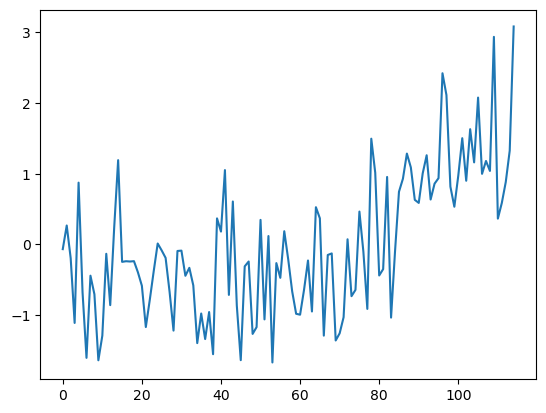

In [44]:
hgt_850=hgt['hgt'].sel(level='850',lon=slice(80,100), lat=slice(10,30)).mean(dim=['lat','lon'])
hgt_850_nm = (hgt_850-np.mean(hgt_850))/np.std(hgt_850)
plt.plot(hgt_850_nm)
hgt_850_nm_detrend=signal.detrend(hgt_850_nm)
hgt_df_detrend=pd.DataFrame(hgt_850_nm_detrend, index=index1[:-1], columns=['hgt_850'])
print(np.corrcoef(signal.detrend(hgt_850_nm.values.squeeze()),signal.detrend(pcs[:,1][:-1])))

# depression

In [45]:
data = pd.read_csv('/home/cccr/roxy/athira/depression/depression_frequency.txt', comment='#', header=None, delim_whitespace=True)
data.columns=['year','JF','MAM','JJAS','OND','ANNUAL']
data.set_index('year',inplace=True)
dpfreq=data['JJAS'].loc['1901':'2018'].values.squeeze()
dpfreq_nn = dpfreq.copy()
dpfreq = (dpfreq-np.mean(dpfreq))/np.std(dpfreq)
dpfreq_detrend=signal.detrend(dpfreq)
# len(index1)
dpfreq_df_detrend=pd.DataFrame(dpfreq_detrend[:-2], index=index1, columns=['dpfreq'])
# np.corrcoef(dpfreq_df_detrend['dpfreq'],pcs_df_detrend['IPC2'][:-3])
# np.corrcoef(dpfreq_df_detrend,pcs_df_detrend['IPC2'][:-3])

## Correlation Dataframe

In [46]:
df=pd.concat([pcs_df_detrend['IPC2'][:-1],dpfreq_df_detrend,hgt_df_detrend,vor_anom_700_df_detrend,vor_anom_850_df_detrend],axis=1)
df.corr()

,IPC2,dpfreq,hgt_850,vor_anom_700,vor_anom_850
IPC2,1.000000,-0.281533,0.337330,-0.289285,-0.362965
dpfreq,-0.281533,1.000000,-0.329250,0.008421,0.032018
hgt_850,0.337330,-0.329250,1.000000,-0.437375,-0.468764
vor_anom_700,-0.289285,0.008421,-0.437375,1.000000,0.963553
vor_anom_850,-0.362965,0.032018,-0.468764,0.963553,1.000000


In [47]:
dpfreq_df=pd.DataFrame(dpfreq[:-2], index=index1, columns=['dpfreq'])
dpfreq_df_nn=pd.DataFrame(dpfreq_nn[:-2], index=index1, columns=['dpfreq'])
hgt_df=pd.DataFrame(hgt_850_nm, index=index1[:-1], columns=['hgt_850'])

In [48]:
vor_anom_850.mean(dim='time')

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    float32 850.0
Data variables:
    VOR      float32 1.05e-14

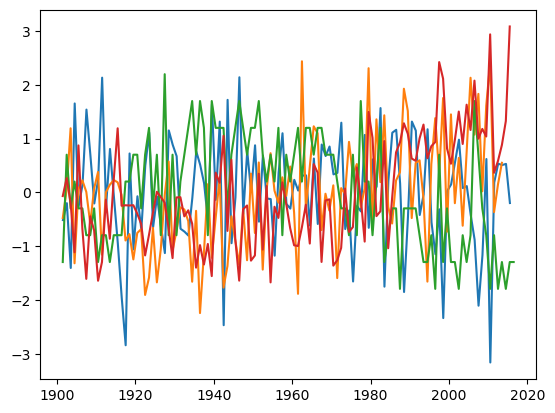

In [49]:
# plt.plot(vor_anom_850['VOR'])
vor_anom_850=(vor_anom_850-vor_anom_850.mean(dim='time'))/vor_anom_850.std(dim='time')
plt.plot(vor_anom_850['time'],vor_anom_850['VOR'])
plt.plot(pcs_df['IPC2'][:-3])
plt.plot(dpfreq_df['dpfreq'])
plt.plot(hgt_df['hgt_850'])

# dpfreq

In [50]:
vor_anom_850_df_detrend=pd.DataFrame(vor_anom_850_detrend, index=index1[:-1], columns=['vor_anom_850'])

####   storing 

In [51]:
%store vor_anom_850
%store pcs_df
%store hgt_df
%store dpfreq_df
%store dpfreq_df_nn
%store dpfreq_df_detrend

%store vor_anom_850_df_detrend
%store hgt_df_detrend

Stored 'vor_anom_850' (Dataset)
Stored 'pcs_df' (DataFrame)
Stored 'hgt_df' (DataFrame)
Stored 'dpfreq_df' (DataFrame)
Stored 'dpfreq_df_nn' (DataFrame)
Stored 'dpfreq_df_detrend' (DataFrame)
Stored 'vor_anom_850_df_detrend' (DataFrame)
Stored 'hgt_df_detrend' (DataFrame)


In [52]:
%store -r no_active
%store -r no_break

no stored variable or alias no_active
no stored variable or alias no_break


In [53]:
np.corrcoef(no_active,signal.detrend(pcs[:,1][:-1]))

NameError: name 'no_active' is not defined